# Exploratory Data Analysis: Spatiotemporal Matrix

This notebook verifies the "Physics" of the constructed spatiotemporal tensor.
We check for:
1. **Linear Growth:** Headways should increase linearly (0, 1, 2...) until a train arrives.
2. **Reset:** Headways should drop to 0 upon train arrival.
3. **Movement:** Trains should appear as diagonal "valleys" of 0s moving across stations over time.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
MATRIX_PATH = "../data/headway_matrix_full.npy"
STATION_PATH = "../data/a_line_station_distances.csv"
SCHEDULE_PATH = "../data/schedule_matrix_full.npy"

# Load Data
print("Loading Data...")
data = np.load(MATRIX_PATH)
schedule = np.load(SCHEDULE_PATH)
station_map = pd.read_csv(STATION_PATH)

print(f"Headway Matrix Shape: {data.shape}")
print(f"Schedule Matrix Shape: {schedule.shape}")
print(f"Stations: {len(station_map)}")


Loading Data...
Headway Matrix Shape: (264211, 156, 2, 1)
Schedule Matrix Shape: (264211, 2, 1)
Stations: 156


## 1. Verify Physics (Sawtooth Wave)
We plot the time series for a single station. It should look like a sawtooth wave.


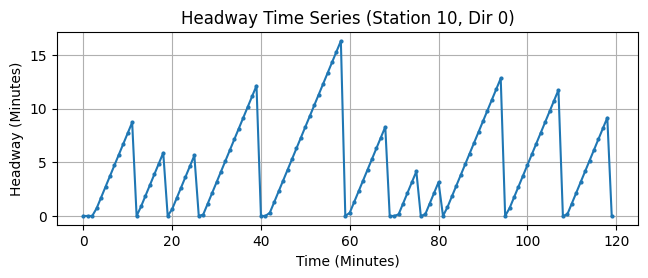

First 20 values (Minutes):
[0.         0.         0.         0.71666667 1.71666667 2.71666667
 3.71666667 4.71666667 5.71666667 6.71666667 7.71666667 8.71666667
 0.         0.88333333 1.88333333 2.88333333 3.88333333 4.88333333
 5.88333333 0.        ]


In [3]:
# Select a station (e.g., index 10) and direction 0 (Northbound)
station_idx = 10
direction_idx = 0
time_steps = 120 # 2 hours

# Extract series
# Shape is (Time, Station, Direction, 1)
# Multiply by 30 to convert back to minutes (Normalization factor from Notebook 3)
series = data[:time_steps, station_idx, direction_idx, 0] * 30

# Plot
plt.figure(figsize=(7.5, 2.5))
plt.plot(series, marker='o', markersize=2)
plt.title(f"Headway Time Series (Station {station_idx}, Dir {direction_idx})")
plt.xlabel("Time (Minutes)")
plt.ylabel("Headway (Minutes)")
plt.grid(True)
plt.show()

# Check values
print("First 20 values (Minutes):")
print(series[:20])


## 2. Verify Train Movement (Space-Time Heatmap)
We plot a heatmap where X=Station, Y=Time.
Trains should appear as dark lines (low headway) moving across stations.

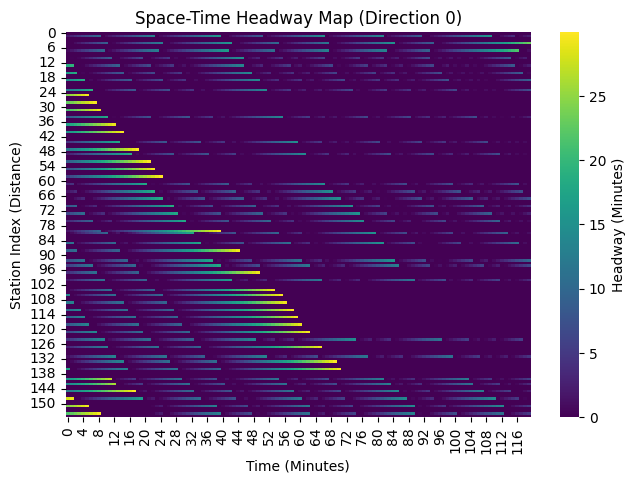

In [4]:
# Select a time window
start_t = 600 # 10:00 AM approx
end_t = 720   # 12:00 PM approx
direction_idx = 0 # Northbound

# Extract slice: (Time, Station)
# Multiply by 30 to convert back to minutes
heatmap_data = data[start_t:end_t, :, direction_idx, 0] * 30

# Transpose so Distance is on Y-axis, Time on X-axis
heatmap_data = heatmap_data.T

plt.figure(figsize=(7.5, 5))
sns.heatmap(heatmap_data, cmap="viridis", cbar_kws={'label': 'Headway (Minutes)'})
plt.title(f"Space-Time Headway Map (Direction {direction_idx})")
plt.xlabel("Time (Minutes)")
plt.ylabel("Station Index (Distance)")
plt.show()


## 3. Visualize Input (X) vs Target (Y) Sample
Here we visualize a single training sample to illustrate the prediction task.
*   **Input X (Left):** The past 30 minutes of headway evolution.
*   **Target Y (Right):** The future 15 minutes we want to predict.
The model must learn to extrapolate the "lines" (train trajectories) from the left into the right.

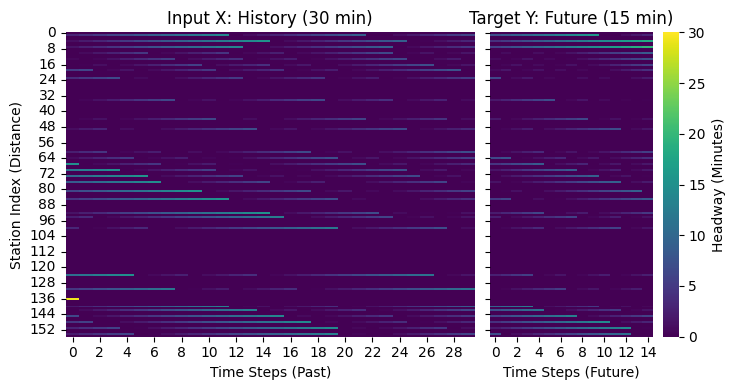

In [5]:
# Configuration
LOOKBACK = 30
FORECAST = 15
current_t = 700 # Arbitrary split point (e.g., 11:40 AM)
direction_idx = 0

# Extract X (History) and Y (Future)
# Transpose for (Space, Time) visualization
# Multiply by 30 to convert to minutes
X_sample = data[current_t-LOOKBACK:current_t, :, direction_idx, 0].T * 30
Y_sample = data[current_t:current_t+FORECAST, :, direction_idx, 0].T * 30

# Plot side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.5, 4), sharey=True, gridspec_kw={'width_ratios': [2, 1]})

# Plot X (History)
sns.heatmap(X_sample, ax=ax1, cmap="viridis", cbar=False, vmin=0, vmax=30)
ax1.set_title(f"Input X: History ({LOOKBACK} min)")
ax1.set_xlabel("Time Steps (Past)")
ax1.set_ylabel("Station Index (Distance)")
ax1.invert_yaxis() # Optional: match standard map orientation if needed, but usually index 0 is top or bottom depending on preference. 
# Let's keep default heatmap orientation (0 at top)

# Plot Y (Future)
sns.heatmap(Y_sample, ax=ax2, cmap="viridis", cbar_kws={'label': 'Headway (Minutes)'}, vmin=0, vmax=30)
ax2.set_title(f"Target Y: Future ({FORECAST} min)")
ax2.set_xlabel("Time Steps (Future)")

plt.tight_layout()
plt.show()


## 4. Reconstructing Trajectories (Abstract Style)
The image you referenced plots **Train Trajectories** (lines showing where trains are).
Our heatmap plots **Headway** (how long we've waited *since* a train passed).

*   **Abstract Image:** Lines = Trains.
*   **Our Heatmap:** Dark Valleys (0 value) = Trains.

To visualize the data exactly like the abstract, we can filter our matrix for points where `Headway == 0` (Arrivals) and plot them as points. These points form the diagonal lines you see in the scientific literature.